# Loan Default Prediction

1. Split training data into training set and valudation set.

Import the required packages. Since i am using google collabs, i mount my drive as well.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import re
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then i loaded the data as train and X_test. Since there are over 130 thousands of non-default data and over 50 thousands of default data, we should resample the training set to improve models prediction. I resample by randomly draw default data and add duplicate it in training set to balance out default / non-default ratio. Since the data contain categorical and date variables, I pre-process them through a function pre_process(train, X_test). I then split the variables and result in order to split train into training set and validation set. Through one-hot encoding, i added more variables to training, validation, and testing sets.

In [58]:
#load data
train = pd.read_csv('/content/drive/MyDrive/Midterm Project/Data/train_data.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Midterm Project/Data/test_data.csv')
print(f'train dataframe shape before:{train.shape}')
print(f'X_test dataframe shape before:{X_test.shape}')

#adding copied default data to balance out training set
train_default = train[train['loan_default'] == 1]
sample_default = train_default.sample(len(train) - 2 * len(train_default), replace=True)
train = pd.concat([train, sample_default], ignore_index=True)
print(f'train shape after resample:{train.shape}')

'''
one-hot encoder encoding Employment.Type, PERFORM_CNS.SCORE.DESCRIPTION (20 categories in train, 19 in test)
'''
def pre_process(train, X_test):
    # data pre-processing for both train and X_test, returns 2 of them separately
    
    #delete UniqueID as it provides no help, process at the end of function...
    
    #turn Date.of.Birth into age: 2021 - year of birth, delete Date.of.Birth at the end of function...
    train['age'] = [datetime.now().year-datetime.strptime(i,"%d/%m/%Y").year for i in train['Date.of.Birth'].to_list()]
    X_test['age'] = [datetime.now().year-datetime.strptime(i,"%d/%m/%Y").year for i in X_test['Date.of.Birth'].to_list()]
    
    #turn DisbursalDate into date till now, delete DisbursalDate at the end of function...
    train['TimeFromDisbursal'] = [(datetime.now()-datetime.strptime(i,"%d/%m/%Y")).days for i in train['DisbursalDate'].to_list()]
    X_test['TimeFromDisbursal'] = [(datetime.now()-datetime.strptime(i,"%d/%m/%Y")).days for i in X_test['DisbursalDate'].to_list()]
    
    #turn Employment.Type into one-hot encoding (2 categories total)
    #data['Employment.Type'].value_counts() #two categories in total
    #data['Employment.Type'] = pd.factorize(data['Employment.Type'])[0]
    encoder_em = OneHotEncoder(sparse=False)
    onehot_em = encoder_em.fit_transform(train['Employment.Type'].fillna('Unemployed').values.reshape(-1,1))
    onehot_em = pd.DataFrame(onehot_em)
    #one-hot transform test data without fit
    onehot_em_test = pd.DataFrame(encoder_em.transform(X_test['Employment.Type'].fillna('Unemployed').values.reshape(-1,1)))
    #drop the original column, process at the end of function...

    #one-hot encoding PERFORM_CNS.SCORE.DESCRIPTION, as it has 20 categories
    encoder_score = OneHotEncoder(sparse=False)
    onehot_score = encoder_score.fit_transform(train['PERFORM_CNS.SCORE.DESCRIPTION'].values.reshape(-1,1))
    onehot_score = pd.DataFrame(onehot_score)
    #one-hot transform test data without fit as it only have 19 categorires 
    onehot_score_test = pd.DataFrame(encoder_score.transform(X_test['PERFORM_CNS.SCORE.DESCRIPTION'].values.reshape(-1,1)))
    #drop the original column, process at the end of function...

    #delete PERFORM_CNS.SCORE as it contains too many unique variables provides no other info but PERFORM_CNS.SCORE
    
    #turn AVERAGE.ACCT.AGE into number of days (assuming month=30days, year=365days)
    lis = [list(map(int,re.findall(r'\d+',i)))for i in train['AVERAGE.ACCT.AGE'].to_list()]
    train['AVERAGE.ACCT.AGE'] = [365*i[0]+30*i[1] for i in lis]
    lis2 = [list(map(int,re.findall(r'\d+',i)))for i in X_test['AVERAGE.ACCT.AGE'].to_list()]
    X_test['AVERAGE.ACCT.AGE'] = [365*i[0]+30*i[1] for i in lis2]
    
    #turn CREIDT.HISTORY.LENGTH into number of days (assuming month=30days, year=365days)
    lis3 = [list(map(int,re.findall(r'\d+',i)))for i in train['CREDIT.HISTORY.LENGTH'].to_list()]
    train['CREDIT.HISTORY.LENGTH'] = [365*i[0]+30*i[1] for i in lis3]
    lis4 = [list(map(int,re.findall(r'\d+',i)))for i in X_test['CREDIT.HISTORY.LENGTH'].to_list()]
    X_test['CREDIT.HISTORY.LENGTH'] = [365*i[0]+30*i[1] for i in lis4]
    
    #drop all old duplicated columns
    train = train.drop(columns=['UniqueID','Date.of.Birth','DisbursalDate','Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'])
    X_test = X_test.drop(columns=['UniqueID','Date.of.Birth','DisbursalDate','Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','PERFORM_CNS.SCORE'])

    #concate all one-hot dataframes with original data
    train = pd.concat([train, onehot_em, onehot_score], axis=1)
    X_test = pd.concat([X_test, onehot_em_test, onehot_score_test], axis=1)

    return train, X_test

#pre-process train and test data
train, X_test = pre_process(train, X_test)

#split training set into X and y
X_tv = train.drop(columns=['loan_default'])
y_tv = train['loan_default']

#split X and y into training and validation set
X_train,X_valid,y_train,y_valid = train_test_split(X_tv,y_tv,test_size=0.2,random_state=1)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape)

train dataframe shape before:(174865, 41)
X_test dataframe shape before:(58289, 40)
train shape after resample:(273496, 41)
(218796, 59) (218796,)
(54700, 59) (54700,)
(58289, 59)


In [59]:
# Stadndardize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [60]:
# PCA on variables
pca = PCA(0.95) #retain 95% of variance
pca.fit(X_train) #fit pca on training set
X_train = pca.transform(X_train) #apply mapping
X_valid = pca.transform(X_valid) #apply mapping
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape)

(218796, 43) (218796,)
(54700, 43) (54700,)
(58289, 59)


In [61]:
#check the columns of X_train
pd.set_option('max_columns', None)
print(X_train)

[[-0.19388002 -0.09094595 -1.24135673 ... -0.29006143 -0.20771122
   0.69385381]
 [-1.98868072  0.49561983  1.33246096 ...  0.09901214  0.07694407
  -0.37113537]
 [-1.70871747  0.19883042  1.2326495  ... -0.08059805  0.10287582
  -0.15420068]
 ...
 [-1.20218373  0.25702369  0.02549785 ... -1.22383977  0.26732526
  -0.32426984]
 [ 0.3235602  -0.23800156  3.76342142 ...  1.46543965 -0.50735423
   0.59129595]
 [-1.58437703  0.40315825 -0.03716586 ...  1.43389041 -0.34641292
   0.8011255 ]]


2. Select classification models to predict loan default.

I have used several models for prediction: Naive Bayes, Stochastic Gradient Descend, Knn, Logistic Regression, Decision Tree, and Random Forest. Since some models are not introduced in the course MF815, they will be process as a reference.
I calibrate the best N for KNN model by looping through different Ns and find the one with highest F1 score. N is at best at 19.
https://www.kaggle.com/getting-started/143685

Number of default for Naive Bayes: 38021
Model Accuracy: 0.5480804387568555
Model F1 Score: 0.6201131054831571
Confusion Matrix:
[[ 9804 17845]
 [ 6875 20176]]
AUC:
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.589


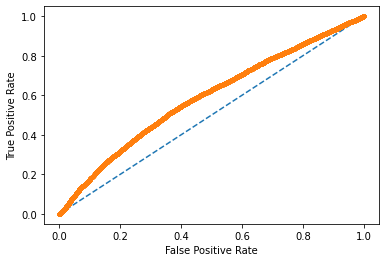

In [62]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred_nb = nb.predict(X_valid)

print(f'Number of default for Naive Bayes: {sum(y_pred_nb)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_nb)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_nb)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_nb)}')
print(f'AUC:')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = nb.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Number of default for Stochastic Gradient Descent: 28312
Model Accuracy: 0.5626142595978062
Model F1 Score: 0.567852175640771
Confusion Matrix:
[[15056 12593]
 [11332 15719]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.590


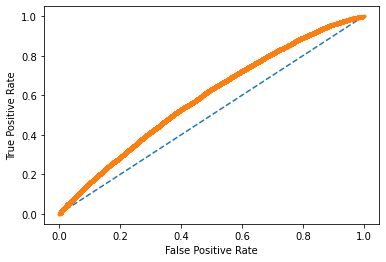

In [63]:
# Stochastic Gradient Descend
sgd = SGDClassifier(loss='modified_huber',shuffle=True,random_state=101)
sgd.fit(X_train,y_train)
y_pred_sgd = sgd.predict(X_valid)

print(f'\nNumber of default for Stochastic Gradient Descent: {sum(y_pred_sgd)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_sgd)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_sgd)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_sgd)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = sgd.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# Kmeans
kmeans = 


Number of default for KNN: 30560
Model Accuracy: 0.6278427787934187
Model F1 Score: 0.6466473416535037
Confusion Matrix:
[[15716 11933]
 [ 8424 18627]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.676


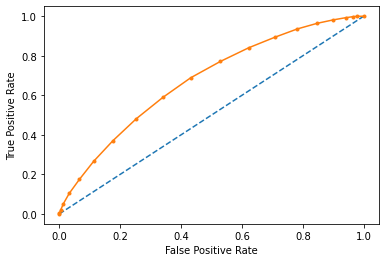

In [64]:
# KNN
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_valid)

print(f'\nNumber of default for KNN: {sum(y_pred_knn)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_knn)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_knn)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_knn)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = knn.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# find the best n for KNN classification model
def knn(n):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train,y_train)
    y_pred_knn = knn.predict(X_valid)
    return accuracy_score(y_valid,y_pred_knn)

knn_bestaccuracy = 0
for i in range(2,20):
    accuracy = knn(i)
    if accuracy > knn_bestaccuracy:
        knn_bestn = i
print(f'Best n for KNN classification: {knn_bestn}')


Number of default for Decision Tree: 29955
Model Accuracy: 0.59345521023766
Model F1 Score: 0.6099007122057326
Confusion Matrix:
[[15078 12571]
 [ 9667 17384]]
No Skill: ROC AUC=0.500
SVM: ROC AUC=0.633


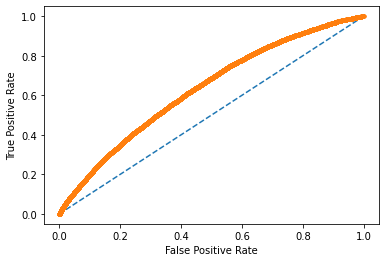

In [65]:
# Logistic Regression
lr = LogisticRegression(solver = 'lbfgs',max_iter = 1000)
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_valid)

print(f'\nNumber of default for Decision Tree: {sum(y_pred_lr)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_lr)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_lr)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_lr)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = lr.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Number of default for Decision Tree: 30529
Model Accuracy: 0.6062157221206581
Model F1 Score: 0.6259117749218478
Confusion Matrix:
[[15140 12509]
 [ 9031 18020]]
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.648


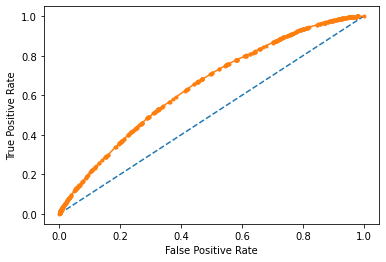

In [66]:
# Decision Tree
dtree = DecisionTreeClassifier(max_depth=10,random_state=101,max_features=None,min_samples_leaf=15)
dtree.fit(X_train,y_train)
y_pred_dtree = dtree.predict(X_valid)

print(f'\nNumber of default for Decision Tree: {sum(y_pred_dtree)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_dtree)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_dtree)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_dtree)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = dtree.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


Number of default for Decision Tree: 29387
Model Accuracy: 0.7797440585009141
Model F1 Score: 0.7865268081788865
Confusion Matrix:
[[20457  7192]
 [ 4856 22195]]
No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.866


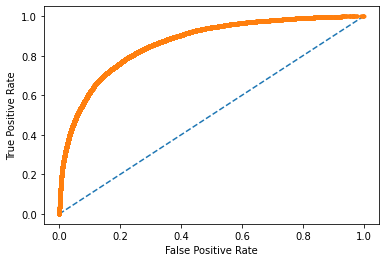

In [67]:
# Random Forest
rf = RandomForestClassifier(n_estimators=70,oob_score=True,n_jobs=-1,random_state=101,max_features=None,min_samples_leaf=30)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_valid)

print(f'\nNumber of default for Decision Tree: {sum(y_pred_rf)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_rf)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_rf)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_rf)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = rf.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# Support Vector Machine (way too slow)
svm = SVC(kernel='linear',random_state=101)
svm.fit(X_train,y_train)
y_pred_svm = svm.predict(X_valid)

print(f'\nNumber of default for Decision Tree: {sum(y_pred_svm)}')
print(f'Model Accuracy: {accuracy_score(y_valid,y_pred_svm)}')
print(f'Model F1 Score: {f1_score(y_valid,y_pred_svm)}')
print(f'Confusion Matrix:\n{confusion_matrix(y_valid,y_pred_svm)}')
ns_probs = [0 for _ in range(len(y_valid))]
lr_probs = svm.predict_proba(X_valid)[:, 1]
ns_auc = roc_auc_score(y_valid, ns_probs)
lr_auc = roc_auc_score(y_valid, lr_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_valid, lr_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

3. select best model, predict loan default

In [57]:
#KNN seems to be the most accurate model
result = knn.predict(X_test)
result_df = pd.read_csv('/content/drive/MyDrive/Midterm Project/Data/test_data.csv')
result_df['loan_default'] = result
#np.savetxt('result.csv', result_df, delimiter=',')
result_df.to_csv('result.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


4. Report performance (accuracy, F1-score for each class, AUC) for models
https://www.jeremyjordan.me/evaluating-a-machine-learning-model/
https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

For each model, I calculated the number of default, model accuracy, model F1 score, confusion matrix, and plotted ROC AUC. Through these visualization, I found that Random Forest has the best prediction result with 0.826 AUC and 0.752 F1 score. Since we haven't cover this model in class, the second best model is KNN with 0.658 AUC and 0.635 F1 score. That's the best model we have, so I concat X_test with KNN prediction in a DataFrame and save it to a CSV file.